# Federated Learning - Régression polynomiale 2D

### Ce fichier a pour but d'aider la visualisation du fonctionnement et des performances du Federated Learning via le Federated Averaging dans un contexte de régression logistique 2D avec 2 classes. Le but de notre modèle est donc de données une bonne prédiction quant à la probabilité d'appartenir à la classe 1.

In [1]:
# Importation des modules de génération de données
from FLSimulator import OneDimensionalRDG, OneDimensionalLRDG, TwoClusterGenerator

# Importation des modèles de machine learning disponibles
from FLSimulator import GDRegressor, LogisticRegressor

# Importation des modules pour créer un réseau fédéré
from FLSimulator import CentralServer, Node, FederatedNetwork

# Importation d'un module a utilisé comme fonction de base phi
from FLSimulator import polynomial_features

# Importation d'une fonction pour regrouper les données de façon centralisé
from FLSimulator import regroup_data_base

# Importation d'autres modules
from random import randint
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

### Créons un réseau fédéré simple constitué de 10 bases de données fédérées disposant de 50 à 80 observations partagées inégalement entre 2 classes dont les points seront tirés de distributions gaussiennes multivariées isotropiques. Le positionnement des moyennes des distributions des classes changeront légèrement entre chaque base de données fédérées pour éviter d'avoir des distributions de classes iid, soit obtenir une situation plus réaliste.

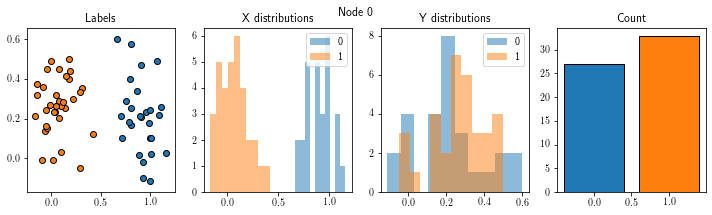

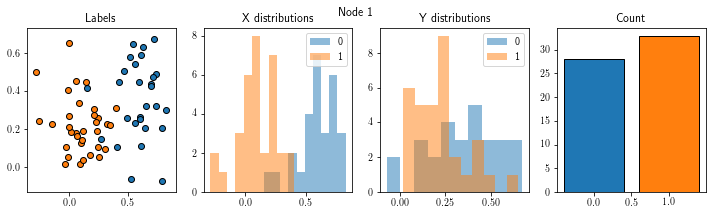

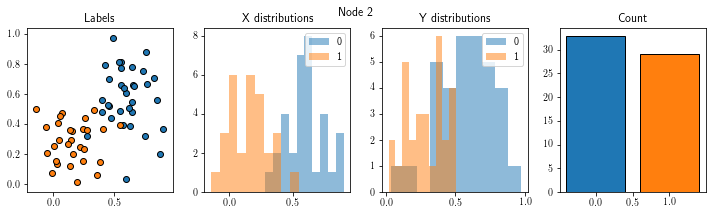

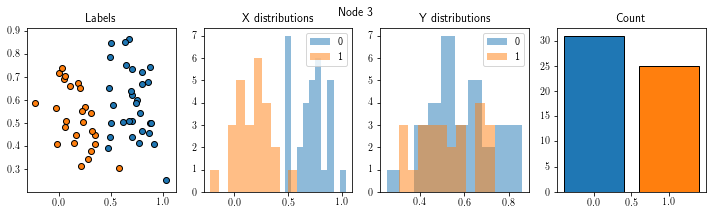

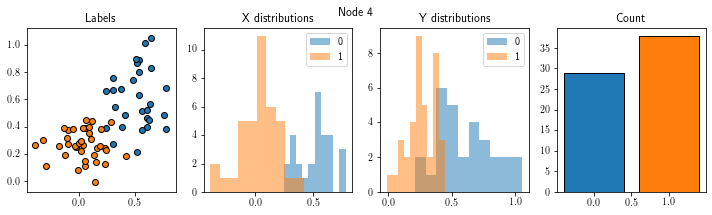

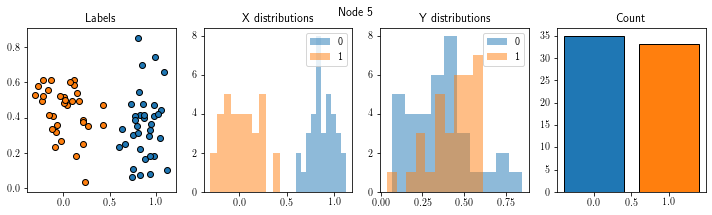

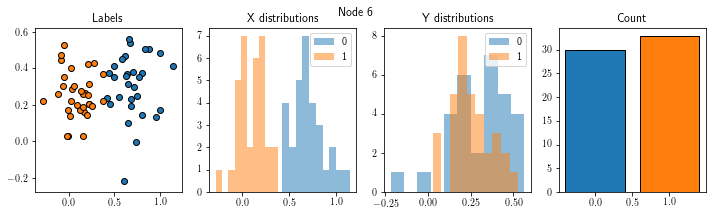

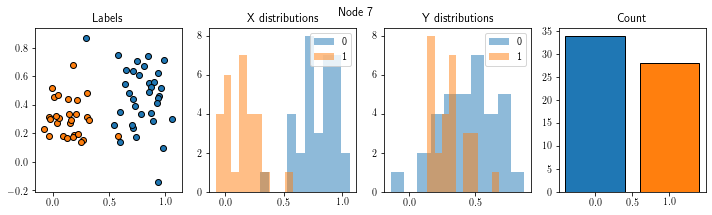

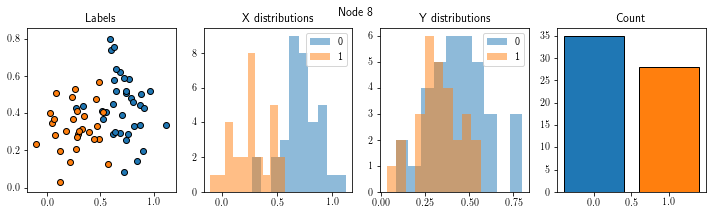

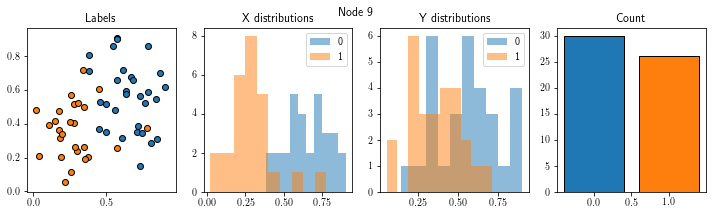

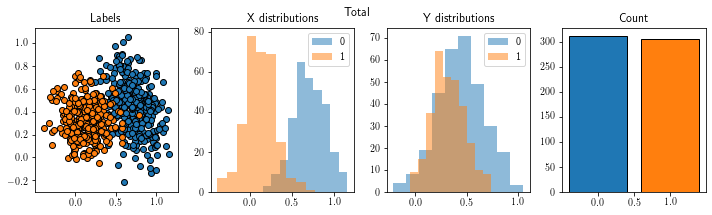

In [2]:
# Activation de LaTeX pour les illustrations
plt.rc('text', usetex=True)

# Création des Node
nodes = []
for i in range(10):
    mu0 = multivariate_normal.rvs([0.70, 0.45], [0.015, 0.015])
    mu1 = multivariate_normal.rvs([0.12, 0.35], [0.015, 0.015])
    n0, n1 = randint(25,40), randint(25,40)
    X, t = TwoClusterGenerator.generate_data(sample_sizes=[n0, n1], centers=[mu0, mu1], std_devs=[[0.025, 0.035], [0.025, 0.015]])
    TwoClusterGenerator.distribution_and_labels(X, t, title='Node ' + str(i))
    nodes.append(Node(X, t))
    
# Illustration de la base de données si elle était centralisée
X_total, t_total = regroup_data_base(nodes)
TwoClusterGenerator.distribution_and_labels(X_total, t_total, title='Total')







In [14]:
# Création du modèle global qui sera entraîné et partagé par le réseau
# Modèle de régression logistique avec fonction de base polynomial de degrés 4
logistic_reg = LogisticRegressor(phi=polynomial_features(4), eta0=1, learning_rate='invscaling')

# Création du server central
#      - Il utilisera le FedAvg pour faire l'aggrégation
#      - Utilisera un sous ensemble aléatoire des nodes ('random') durant chaque round de l'entraînement
#      - Le sous ensemble sera constituté de 80% de l'ensemble des nodes (random_size=0.80)
#      - Utilisera un minibatch size de 1 (C=1) pour les entraînements de chaque Node
#      - Effectuera 250 epochs pour les entraînements de chaque Node

c_server = CentralServer(global_model=logistic_reg, aggregation='FedAvg', node_selection='random', C=1, E=250, random_size=0.80)

In [15]:
# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

### On effectue maintenant 3 "rounds" d'entraînements et visualisons les performances du modèle global à jour entre chaque "round" en regroupant l'ensemble des bases de données dans une figure commune. Notons ici que la loss utilisée correspond à la _cross entropy_

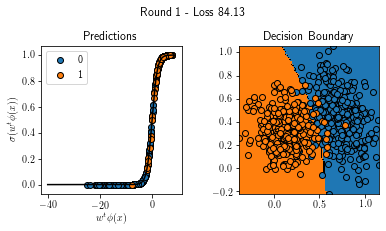

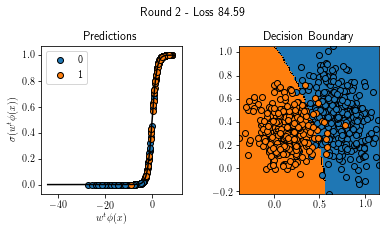

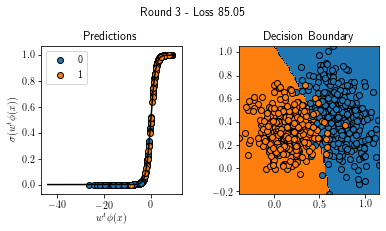

In [16]:
f_network.run_learning(nb_of_rounds=3, show_round_results=True)

### On compare maintenant avec un modèle entraîné localement avec l'ensemble des données

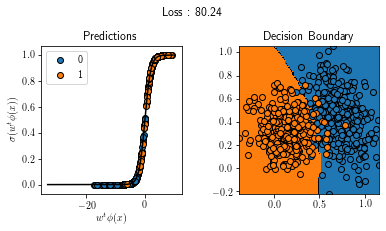

In [13]:
# Création d'un nouveau modèle de régression logistic semblable au modèle global précédent
local_logistic_reg = LogisticRegressor(phi=polynomial_features(4), eta0=1, learning_rate='invscaling')

# Entrainons le localement avec l'ensemble des données et un budget total d'epochs considérable de 1000
# et un minibatch size de 3 pour accélérer le processus
local_logistic_reg.train(X_total, t_total, minibatch_size=3, nb_epoch=1000)

# Comparons le modèle local au modèle fédéré
local_logistic_reg.plot_model(X_total, t_total, title='Loss : ' + str(round(local_logistic_reg.loss(X_total, t_total), 2)))